# Gradient Boosting
(by Tevfik Aytekin)

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
import xgboost as xgb

def kaggle_score(y_true,y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred));
#def kaggle_score(y_true,y_pred):
#    return np.sqrt(mean_squared_error(np.log(y_true), np.log(y_pred)));
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
house_train = pd.read_csv("../datasets/house_prices/train.csv")


### DecisionTreeRegressor
Run DecisionTreeRegressor on House Prices.

In [3]:
X = house_train.loc[:,'MSSubClass':'SaleCondition']
y = house_train.loc[:,'SalePrice']
X = pd.get_dummies(X)
mae, kaggle, mape = [], [], []
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())

    regr = DecisionTreeRegressor()
    regr.fit(X_train, y_train)
    
    test_predictions = regr.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions))
    mape.append(mean_absolute_percentage_error(y_test, test_predictions))
    kaggle.append(kaggle_score(y_test, test_predictions))

print("Test MAE:", np.mean(mae))
print("Test MAPE:", np.mean(mape))
print("Test Kaggle:", np.mean(kaggle))


Test MAE: 26191.478691019787
Test MAPE: 14.863252896990069
Test Kaggle: 0.20336790546856742


### GradientBoostingRegressor
Run sklearn's GradientBoostingRegressor on House Prices dataset

In [4]:
X = house_train.loc[:,'MSSubClass':'SaleCondition']
y = house_train.loc[:,'SalePrice']
X = pd.get_dummies(X)
mae, kaggle, mape = [], [], []
for i in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())

    regr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
    regr.fit(X_train, y_train)
    
    test_predictions = regr.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions))
    mape.append(mean_absolute_percentage_error(y_test, test_predictions))
    kaggle.append(kaggle_score(y_test, test_predictions))

print("Test MAE:", np.mean(mae))
print("Test MAPE:", np.mean(mape))
print("Test Kaggle:", np.mean(kaggle))


Test MAE: 15600.364100192444
Test MAPE: 9.297615525788002
Test Kaggle: 0.13033405163631143


### GradientBoostingRegressor from scratch
Let us write GradientBoostingRegressor from scratch. Note that "learning_rate" is also known as "shrinkage."

In [5]:
class MyGradientBoostingRegressor:
    
    def __init__(self, n_estimators = 100, learning_rate = 0.1, max_depth=3):
        self.models = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
    def calc_grads(self, model, X, y):    
        preds = self.learning_rate * model.predict(X)
        grads = y - preds
        return grads
    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for m in self.models:
            preds += self.learning_rate * m.predict(X)
        return preds
        
    def fit(self, X, y):
        for i in range(self.n_estimators):
            model = DecisionTreeRegressor(max_depth=self.max_depth);
            if (i == 0):
                model.fit(X, y)
                grads = self.calc_grads(model, X, y)
            else:
                model.fit(X, grads)
                grads = self.calc_grads(model, X, grads)
            self.models.append(model)
            
            

### How learning_rate works

learning_rate shrinks the contribution of each tree. This is an important parameter which has significant effect on the error. You can try to set it to 1 and look at the result. Below is a simple illustration:

Suppose that we have only 3 models: M1, M2, and M3 <br>
y = 10 <br>
learning_rate = 1 (no shrinkage)


M1.predict = 8 <br>
grad = 10 - 8 = 2

fit M2 for y = 2 <br>
M2.predict = 1.5 <br>
grad = 2 - 1.5 = 0.5

fit M3 for y = 0.5


Prediction:

M1.predict(X) + M2.predict(X) + M3.predict(X) 

-----------------------
3 models: M1, M2, and M3 <br>
y = 10<br>
learning_rate = 0.1 (with shrinkage)

M1.predict = 8 <br>
grad = 10 - 0.1 x 8 = 9.2

fit M2 for y = 9.2<br>
M2.predict = 7<br>
grad = 9.2 - 0.1 * 7 = 8.5

fit M3 for y = 8.5


Prediction:

0.1 x M1.predict(X) + 0.1 x M2.predict(X) + 0.1 x M3.predict(X) 

**Question:** Why does shrinkage improve performance significantly?




### Example Run
Now let us run our version of GradientBoostingRegressor on the same dataset

In [11]:
from sklearn.metrics import mean_absolute_error
X = house_train.loc[:,'MSSubClass':'SaleCondition']
y = house_train.loc[:,'SalePrice']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

reg1 = DecisionTreeRegressor()
reg2 = GradientBoostingRegressor()
reg3 = MyGradientBoostingRegressor(learning_rate=0.1, max_depth=3)

reg1.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)

print(mean_absolute_percentage_error(y_test, reg1.predict(X_test)))
print(mean_absolute_percentage_error(y_test, reg2.predict(X_test)))
print(mean_absolute_percentage_error(y_test, reg3.predict(X_test)))

14.1011047094693
8.11235961260504
8.039237050397405


### Gradient Boosting Classifier

In [12]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
# print first 5 examples
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [13]:
bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [14]:
bank_majority = bank[bank.y=="no"]
bank_minority = bank[bank.y=="yes"]
 
# downsample
bank_majority_downsampled = resample(bank_majority, 
                                 replace=False,    
                                 n_samples=5289) 
 
bank_balanced = pd.concat([bank_minority, bank_majority_downsampled])
bank_balanced.y.value_counts()

yes    5289
no     5289
Name: y, dtype: int64

### Logistic/Sigmoid function

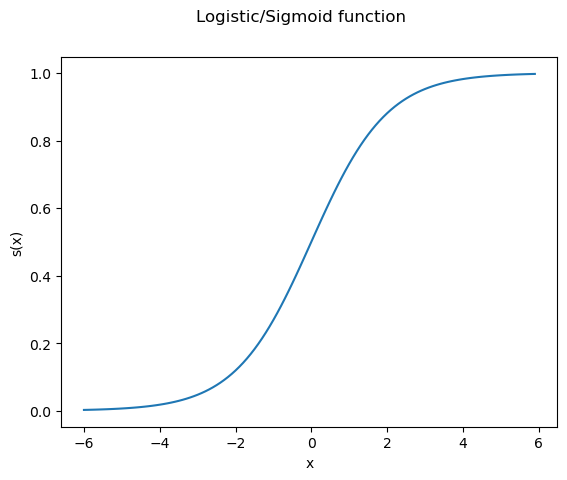

In [15]:
x = np.arange(-6, 6, 0.1)
s = 1 / (1 + np.exp(-x))
plt.plot(x, s)
plt.xlabel('x')
plt.ylabel('s(x)')
plt.suptitle("Logistic/Sigmoid function")
plt.show()

In [16]:
class MyGradientBoostingClassifier:
    
    def cross_ent(self, y, p):
        return - y * np.log(p) - (1 - y) * np.log(1 - p)
    
    def diff(self, y, p):
        return y - p
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x)) 
    
    def __init__(self, n_estimators = 100, learning_rate = 0.1, max_depth=3):
        self.models = []
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        
    def calc_grads(self, model, X, y):    
        preds = self.learning_rate * model.predict(X)
        grads = self.diff(y, preds)
        return grads
    
    def predict(self, X):
        preds = np.zeros(X.shape[0])
        for m in self.models:
            preds += self.learning_rate * m.predict(X)
        return np.round(preds)
        
    def fit(self, X, y):
        for i in range(self.n_estimators):
            model = DecisionTreeRegressor(max_depth=2);
            if (i == 0):
                model.fit(X, y)
                grads = self.calc_grads(model, X, y)
            else:
                model.fit(X, grads)
                grads = self.calc_grads(model, X, grads)
            self.models.append(model)
            

In [17]:
X = bank_balanced.loc[:,'age':'poutcome']
y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf1 = DecisionTreeClassifier()
clf2 = GradientBoostingClassifier()
clf3 = MyGradientBoostingClassifier()

clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);
clf3.fit(X_train, y_train);

y_pred1 = clf1.predict(X_test)  
y_pred2 = clf2.predict(X_test) 
y_pred3 = clf3.predict(X_test) 

print(classification_report(y_test,y_pred1))
print(classification_report(y_test,y_pred2))
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76       514
           1       0.78      0.78      0.78       544

    accuracy                           0.77      1058
   macro avg       0.77      0.77      0.77      1058
weighted avg       0.77      0.77      0.77      1058

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       514
           1       0.83      0.89      0.86       544

    accuracy                           0.85      1058
   macro avg       0.85      0.85      0.85      1058
weighted avg       0.85      0.85      0.85      1058

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       514
           1       0.83      0.87      0.85       544

    accuracy                           0.84      1058
   macro avg       0.85      0.84      0.84      1058
weighted avg       0.85      0.84      0.84      1058



### XGBoost Regression

In [26]:

X = house_train.loc[:,'MSSubClass':'SaleCondition']
y = house_train.loc[:,'SalePrice']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

reg1 = DecisionTreeRegressor()
reg2 = GradientBoostingRegressor()
reg3 = MyGradientBoostingRegressor()
reg4 = xgb.XGBRegressor()


reg1.fit(X_train, y_train)
reg2.fit(X_train, y_train)
reg3.fit(X_train, y_train)
reg4.fit(X_train, y_train)

print(mean_absolute_percentage_error(y_test, reg1.predict(X_test)))
print(mean_absolute_percentage_error(y_test, reg2.predict(X_test)))
print(mean_absolute_percentage_error(y_test, reg3.predict(X_test)))
print(mean_absolute_percentage_error(y_test, reg4.predict(X_test)))

13.911814085006927
6.8670497260696965
6.8758043918565495
7.739347153149769


XGBoost can handle missing values.

In [24]:
X = house_train.loc[:,'MSSubClass':'SaleCondition']
y = house_train.loc[:,'SalePrice']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
reg4 = xgb.XGBRegressor()
reg4.fit(X_train, y_train)
print(mean_absolute_percentage_error(y_test, reg4.predict(X_test)))

10.703288098337424


### XGBoost Classification

In [73]:
X = bank_balanced.loc[:,'age':'poutcome']
y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
 
clf1 = DecisionTreeClassifier()
clf2 = GradientBoostingClassifier()
clf3 = MyGradientBoostingClassifier()
clf4 = xgb.XGBClassifier()

clf1.fit(X_train, y_train);
clf2.fit(X_train, y_train);
clf3.fit(X_train, y_train);
clf4.fit(X_train, y_train);

y_pred1 = clf1.predict(X_test)  
y_pred2 = clf2.predict(X_test) 
y_pred3 = clf3.predict(X_test)
y_pred4 = clf4.predict(X_test) 

print(classification_report(y_test,y_pred1))
print(classification_report(y_test,y_pred2))
print(classification_report(y_test,y_pred3))
print(classification_report(y_test,y_pred4))

/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:52:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       523
           1       0.79      0.78      0.79       535

    accuracy                           0.79      1058
   macro avg       0.79      0.79      0.79      1058
weighted avg       0.79      0.79      0.79      1058

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       523
           1       0.86      0.87      0.87       535

    accuracy                           0.86      1058
   macro avg       0.86      0.86      0.86      1058
weighted avg       0.86      0.86      0

In [74]:
X = bank_balanced.loc[:,'age':'poutcome']
y = bank_balanced.loc[:,'y']
y = y.replace(["yes","no"],[1,0])
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf4 = xgb.XGBClassifier()
clf4.fit(X_train, y_train);
y_pred4 = clf4.predict(X_test) 
print(classification_report(y_test,y_pred4))

/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:54:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       538
           1       0.86      0.90      0.88       520

    accuracy                           0.88      1058
   macro avg       0.88      0.88      0.88      1058
weighted avg       0.88      0.88      0.88      1058

